# Lecture 1


In this lecture, we will recall the basic facts about decision trees and talk about bootstrap aggregation.

## 1. Decision Trees

![](images/L1/3_2_41c1793bef.png)
[source](https://education.yandex.ru/handbook/ml/article/reshayushchiye-derevya)


### 1.1 Desision Trees Algorithms


```python
min_loss = inf
optimal_border = None

for j in range(D):
    for t in X[:, j]:     
        loss = calculate_loss(t, j, X, y)
        if loss < min_loss:
           min_loss, optimal_border = loss, (j, t)

```

Pros:
- can approximate nonlinear dependencies
 
Cons:
- unstable when changing subsample
- easy to overfit
- not differentiable



In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')

from matplotlib.colors import ListedColormap
from sklearn import tree

In [2]:
# https://github.com/lkriener/yin_yang_data_set

def make_yinyang(r_small=0.1, r_big=0.5, size=1000, seed=42):
    rng = np.random.RandomState(seed)
    
    X = np.zeros((size,2))
    Y = np.zeros(size)


    def dist_to_right_dot(x, y):
        return np.sqrt((x - 1.5 * r_big)**2 + (y - r_big)**2)

    def dist_to_left_dot(x, y):
        return np.sqrt((x - 0.5 * r_big)**2 + (y - r_big)**2)

    def which_class(x, y):
        # equations inspired by
        # https://link.springer.com/content/pdf/10.1007/11564126_19.pdf
        d_right = dist_to_right_dot(x, y)
        d_left = dist_to_left_dot(x, y)
        criterion1 = d_right <= r_small
        criterion2 = d_left > r_small and d_left <= 0.5 * r_big
        criterion3 = y > r_big and d_right > 0.5 * r_big
        is_yin = criterion1 or criterion2 or criterion3
        
        is_circles_1 = d_right < r_small
        is_circles_2 = d_left < r_small
        
        if is_circles_1 or is_circles_2:
            if is_circles_1:
                return 1
            if is_circles_2:
                return 0
        return int(is_yin)
            
    def get_sample(goal=None):
        # sample until goal is satisfied
        found_sample_yet = False
        while not found_sample_yet:
            # sample x,y coordinates
            x, y = rng.rand(2) * 2. * r_big
            # check if within yin-yang circle

            if x > 2*r_big or y > 2 * r_big:
                continue

            c = which_class(x, y)
            if goal is None or c == goal:
                found_sample_yet = True
                break
        return x, y, c

    for i in range(size):
        # keep num of class instances balanced by using rejection sampling
        # choose class for this sample
        goal_class = rng.randint(2)
        x, y, c = get_sample(goal=goal_class)
        
        X[i, :] = x, y
        Y[i] = c


    return X, Y

In [4]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
    y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [5]:
colors = ['red', 'green']
cmap = ListedColormap(colors)

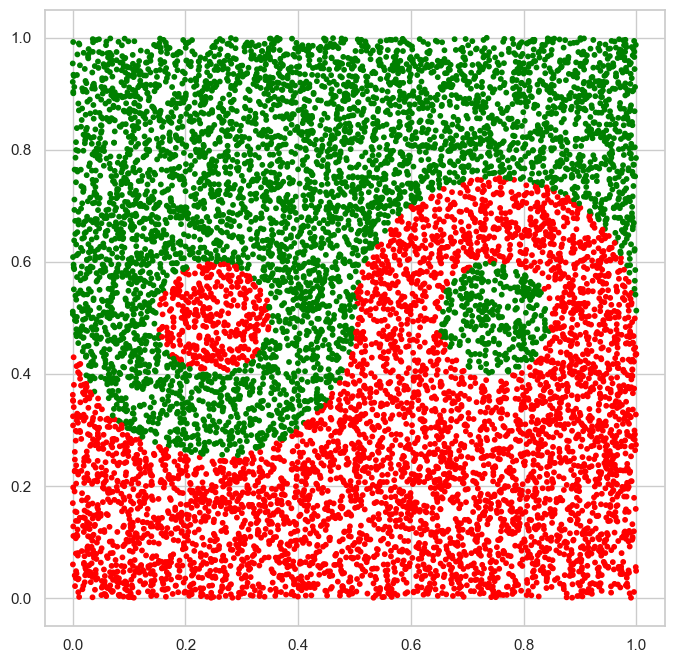

In [18]:
full_data = make_yinyang(size=10000, seed=42, r_small=0.1, r_big=0.5)
plt.figure(figsize=(8, 8))
plt.scatter(full_data[0][:, 0], full_data[0][:, 1],  c=full_data[1], s=10, cmap=cmap)
plt.show()

In [19]:
data_x, data_y = make_yinyang(size=500, seed=42, r_small=0.1, r_big=0.5)

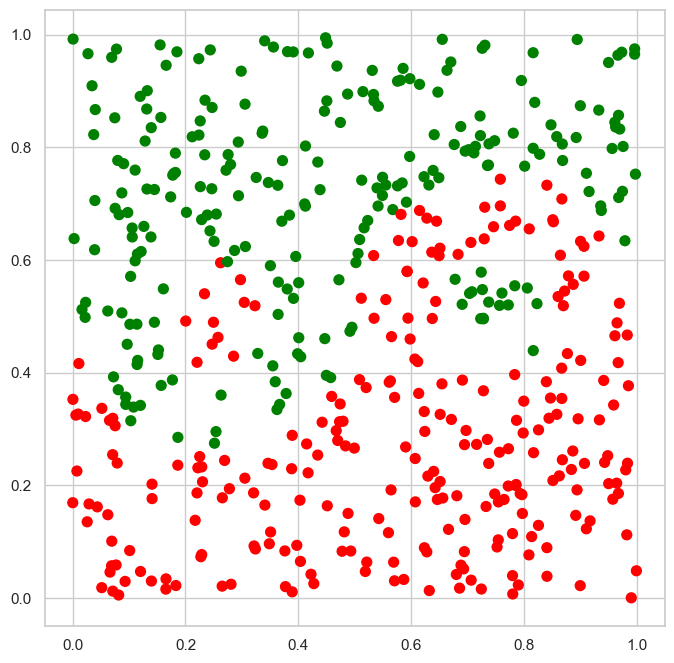

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1],  c=data_y, s=50, cmap=cmap)
plt.show()

In [9]:
from sklearn.tree import DecisionTreeClassifier

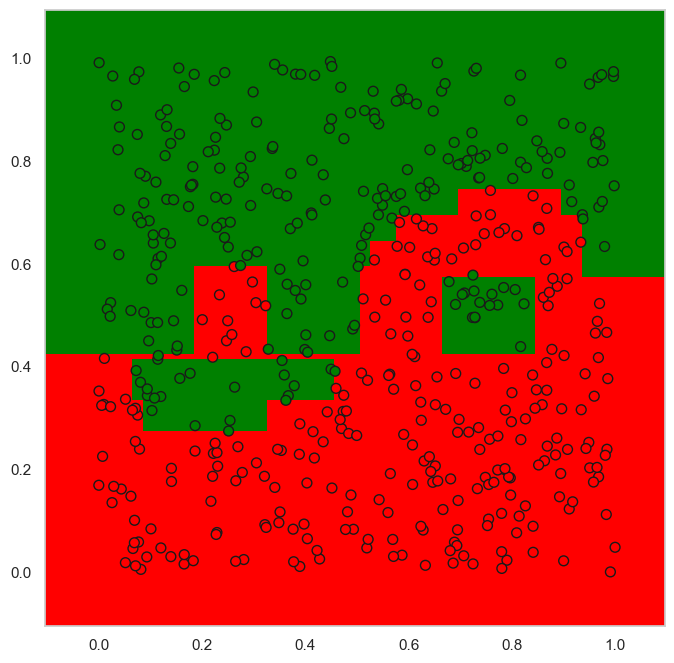

In [42]:
clf = DecisionTreeClassifier(random_state=42, max_depth=100, min_samples_leaf=1)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap=cmap)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=50, cmap=cmap, edgecolor='k')
plt.show()

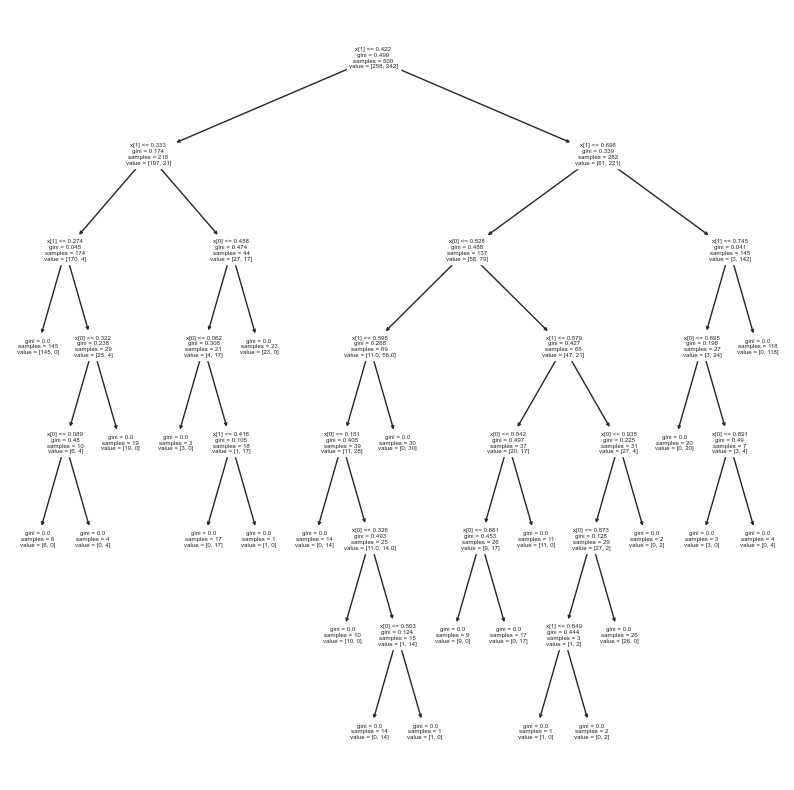

In [43]:
plt.figure(figsize=(10, 10))
tree.plot_tree(clf)
plt.show()

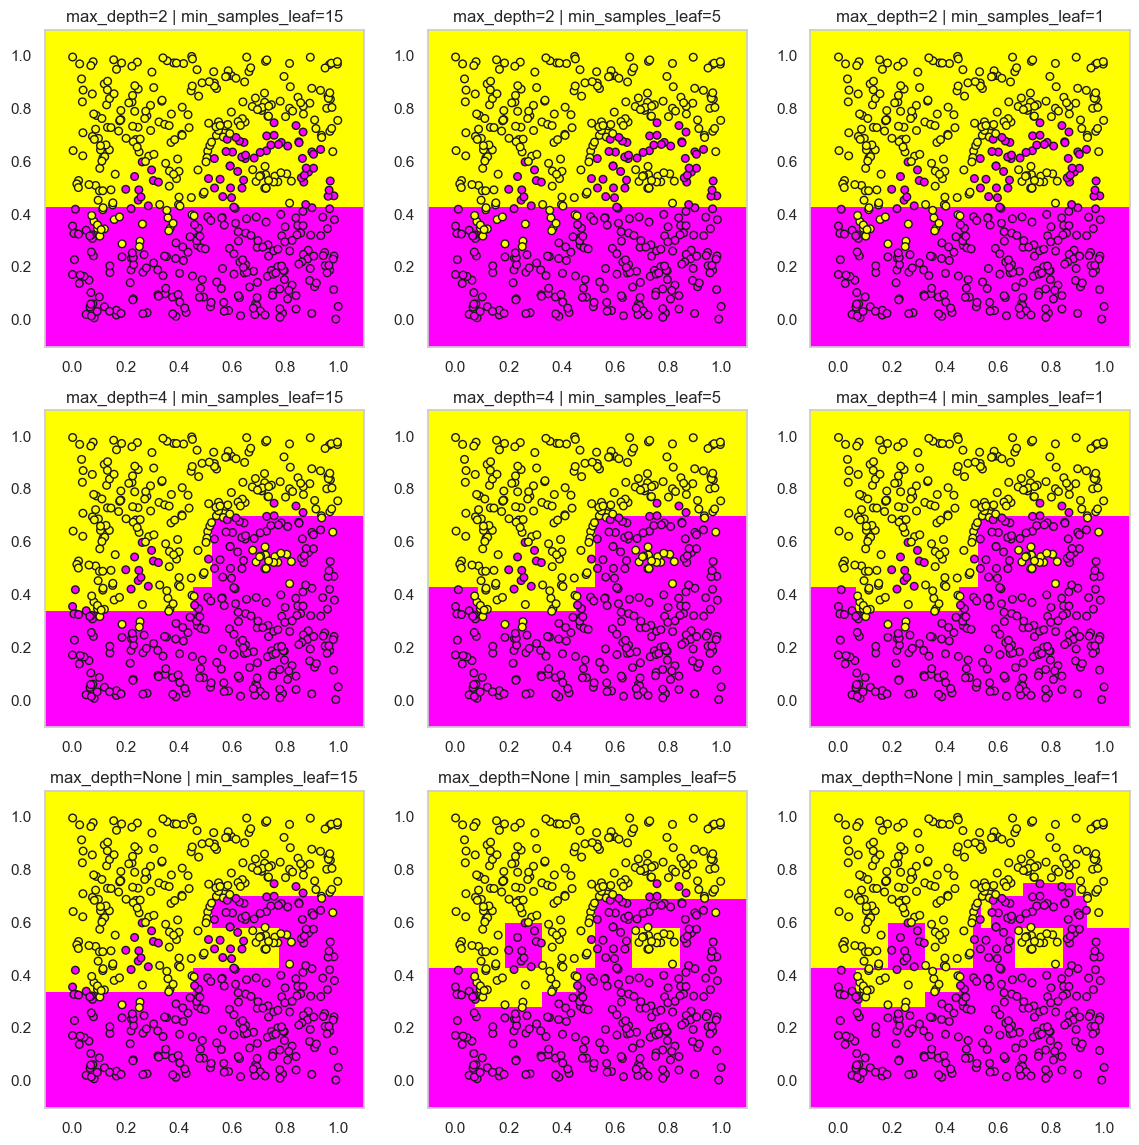

In [26]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

Instability

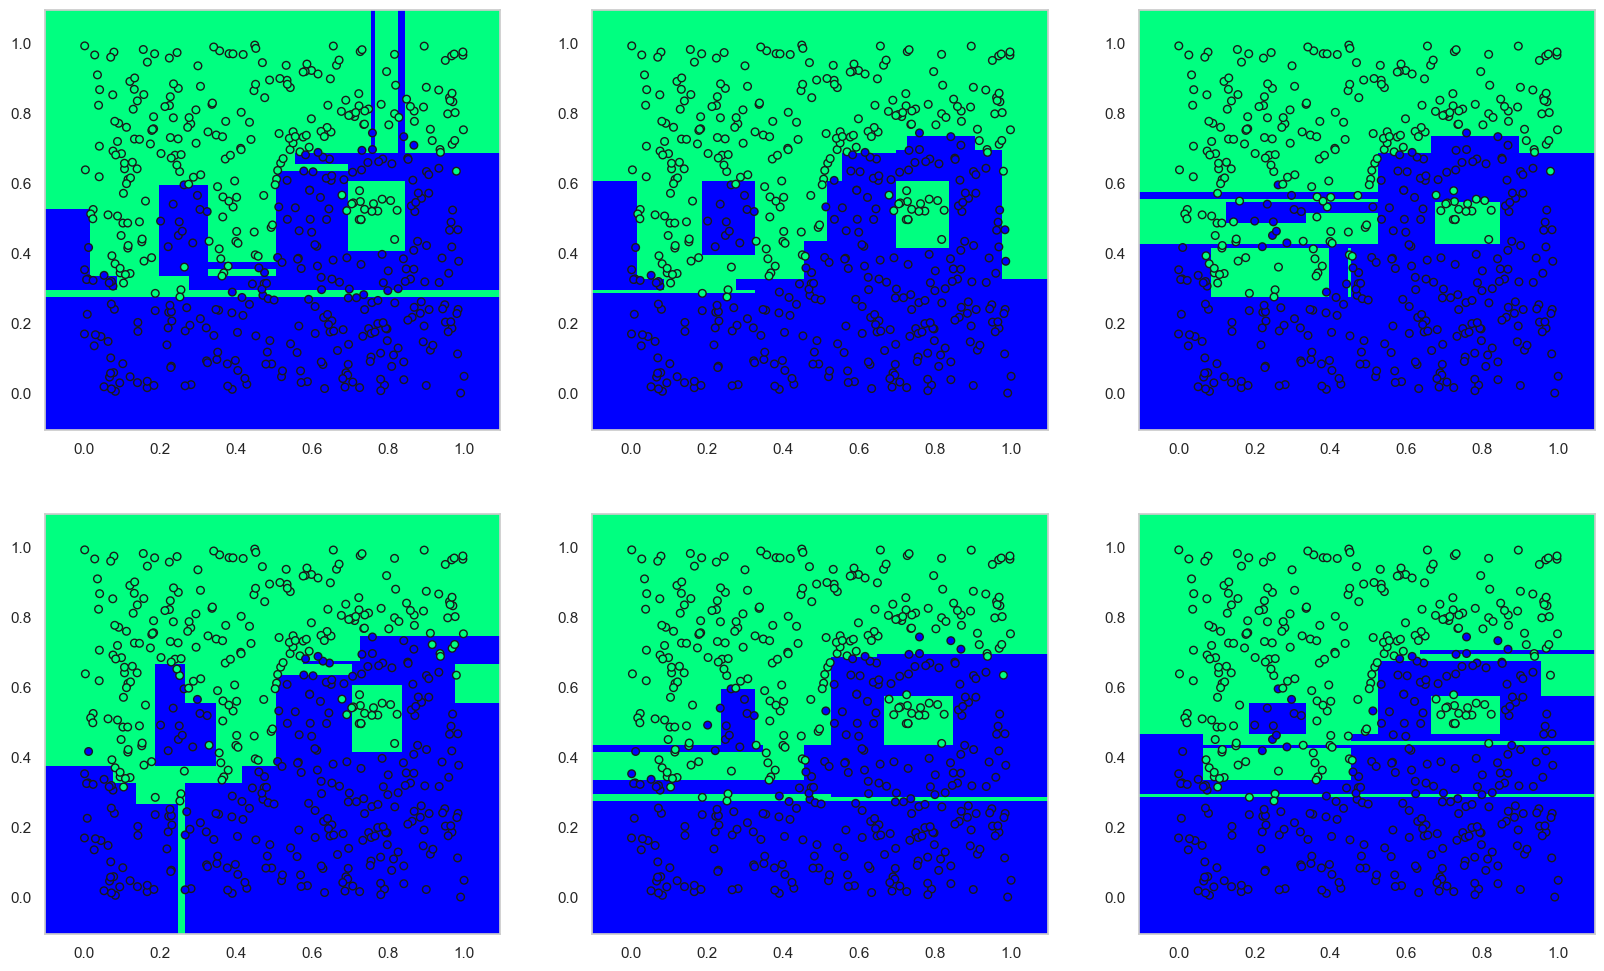

In [45]:
plt.figure(figsize=(20, 12))
for i in range(6):
    clf = DecisionTreeClassifier(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((2, 3), (i//3, i%3))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

# 2. Bagging - bootstrap aggregation


![](images/L1/Bootstrap-aggregation-bagging-in-regression-tree-ensembles.png)
[source](https://www.researchgate.net/figure/Bootstrap-aggregation-bagging-in-regression-tree-ensembles_fig1_349624596)



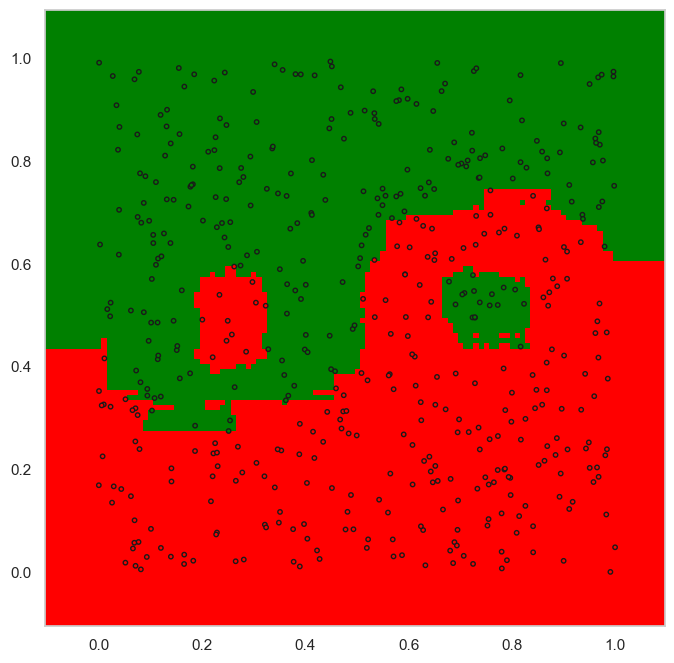

In [46]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)

clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap=cmap)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=10, cmap=cmap, edgecolor='k')

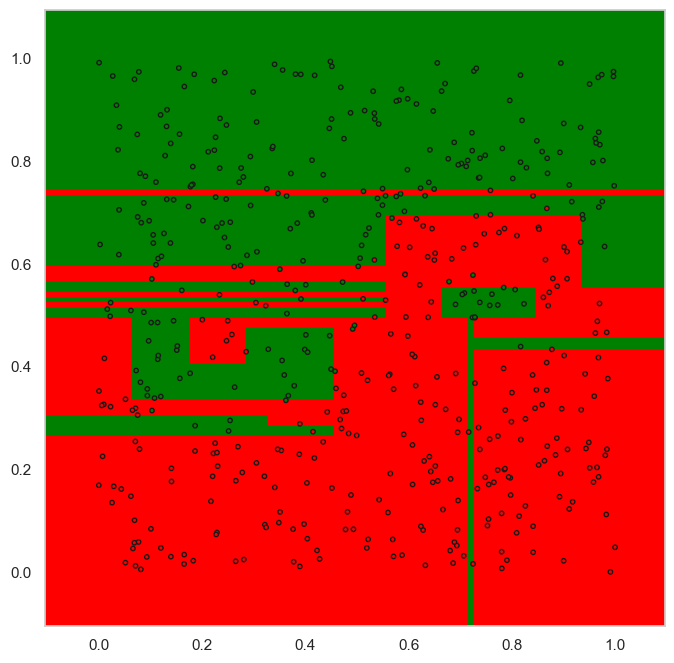

In [47]:
predicted = clf.estimators_[5].predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap=cmap)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=10, cmap=cmap, edgecolor='k')

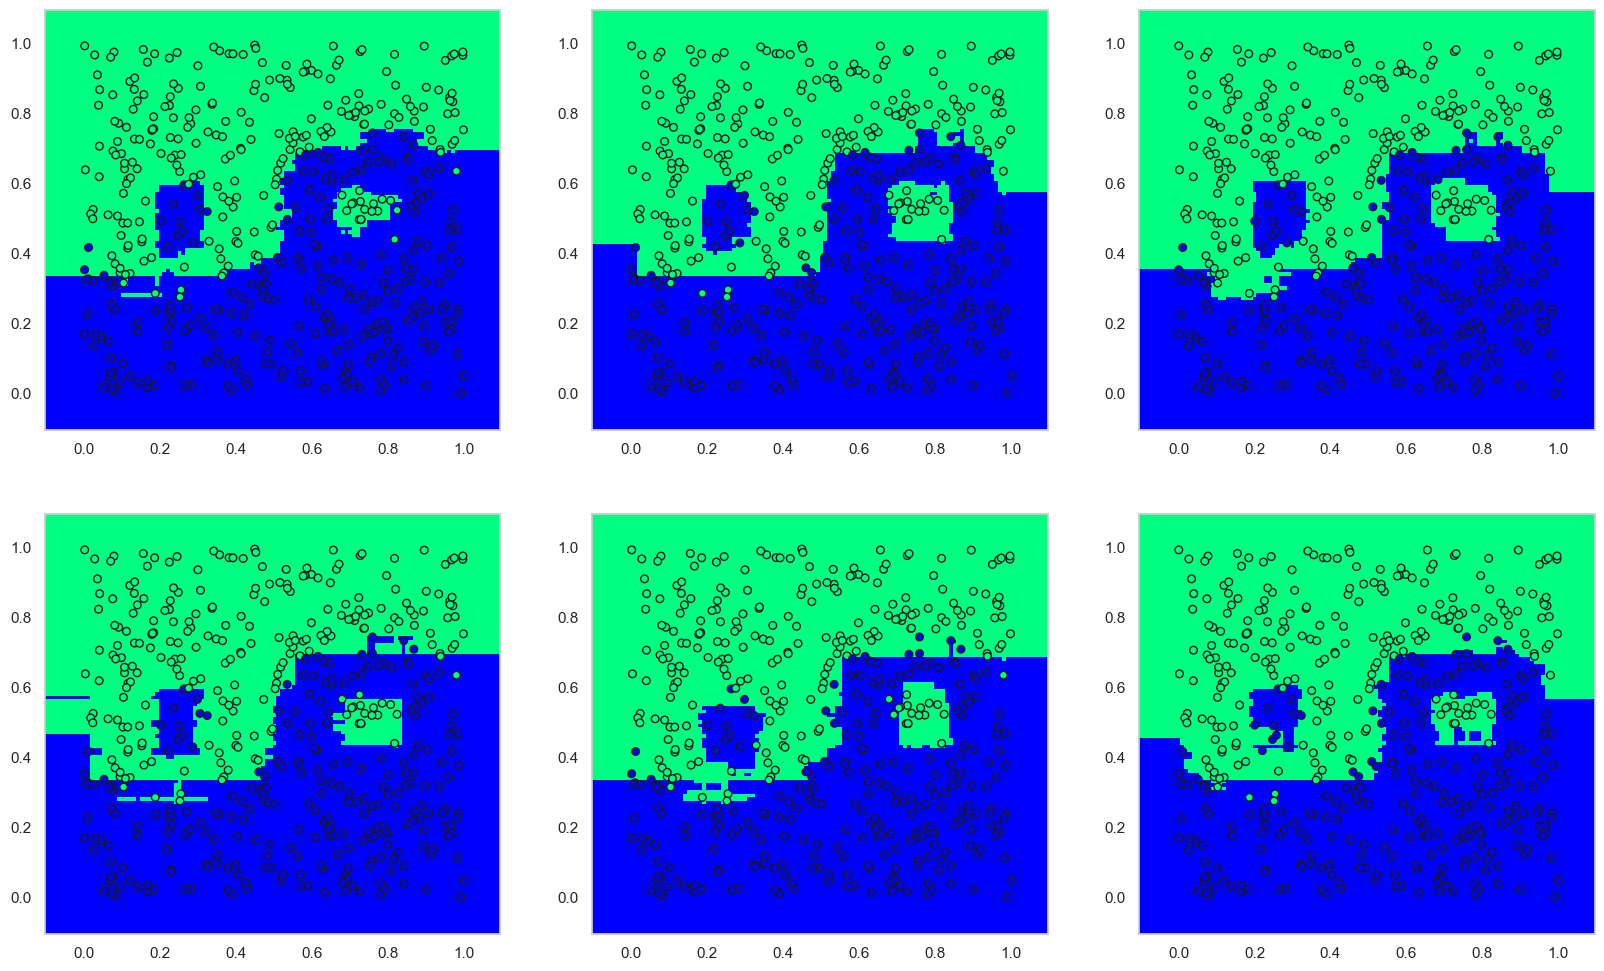

In [16]:
plt.figure(figsize=(20, 12))
rnd_state = np.random.RandomState(42)
for i in range(6):
    clf =  RandomForestClassifier(max_depth=20, random_state=0)

    
    indecies = rnd_state.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((2, 3), (i//3, i%3))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

## How bootstrap aggregation work?

## Bias-variance decomposition



<img src="images/L1/bullseye.png" width="700"/>

Graphical illustration of bias and variance.

Source: http://scott.fortmann-roe.com/docs/BiasVariance.html